### imports

In [1]:
import gc
import os
import pickle
import random
import time
from collections import Counter, defaultdict
from functools import partial
from pathlib import Path
from psutil import cpu_count

import librosa
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
#from skmultilearn.model_selection import iterative_train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, MultiStepLR
from torch.optim.lr_scheduler import CyclicLR
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.models as models

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.set_device(3)

### utils

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2019
seed_everything(SEED)

In [5]:
N_JOBS = cpu_count()
used = int(4)
print(N_JOBS, used)
os.environ['MKL_NUM_THREADS'] = str(used)
os.environ['OMP_NUM_THREADS'] = str(used)
DataLoader = partial(DataLoader, num_workers=used)

56 4


### metric definition
calculate lwlrap for task2.

In [6]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

### dataset

In [7]:
dataset_dir = Path('/media/ky02/dcase2019-data/task2')
preprocessed_dir = Path('./work/fat2019_prep_mels_2s') # time duration of audio croped, 2s 4s1 4s2 2s_pcen;
print(os.listdir(preprocessed_dir))

['mels_train_noisy.pkl', 'trn_noisy_best50s.csv', 'mels_trn_noisy_best50s.pkl', 'mels_test.pkl', 'mels_train_curated.pkl']


In [8]:
csvs = {
    'train_curated': dataset_dir / 'train_curated.csv',
    'train_noisy': dataset_dir / 'train_noisy.csv',
#     'train_noisy': preprocessed_dir / 'trn_noisy_best50s.csv',
    'sample_submission': dataset_dir / 'sample_submission.csv',
}

dataset = {
    'train_curated': dataset_dir / 'train_curated',
    'train_noisy': dataset_dir / 'train_noisy',
    'test': dataset_dir / 'test',
}

mels = {
    'train_curated': preprocessed_dir / 'mels_train_curated.pkl',
    'train_noisy': preprocessed_dir / 'mels_train_noisy.pkl', # 'mels_trn_noisy_best50s.pkl'
    'test': preprocessed_dir / 'mels_test.pkl',  # NOTE: this data doesn't work at 2nd stage
}

In [9]:
train_curated = pd.read_csv(csvs['train_curated'])
train_noisy = pd.read_csv(csvs['train_noisy'])
# train_df = pd.concat([train_curated, train_noisy],sort=True,ignore_index=True)
train_df = pd.concat([train_curated], sort=True, ignore_index=True)
train_df.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [10]:
test_df = pd.read_csv(csvs['sample_submission'])
test_df.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0012633b.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001ed5f1.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00294be0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,003fde7a.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
labels = test_df.columns[1:].tolist()
# print(labels)
num_classes = len(labels)
num_classes

80

In [12]:
y_train = np.zeros((len(train_df), num_classes)).astype(int)
for i, row in enumerate(train_df['labels'].str.split(',')):
    for label in row:
        idx = labels.index(label)
        y_train[i, idx] = 1

y_train.shape

(4970, 80)

In [13]:
with open(mels['train_curated'], 'rb') as curated, open(mels['train_noisy'], 'rb') as noisy:
    x_train = pickle.load(curated)
    print(len(x_train))
#     x_train.extend(pickle.load(noisy))
#     print(len(x_train))

with open(mels['test'], 'rb') as test:
    x_test = pickle.load(test)
    
len(x_train), len(x_test)

4970


(4970, 1120)

### Data loader

In [14]:
class FATTrainDataset(Dataset):
    def __init__(self, mels, labels, transforms):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.mels)
    
    def __getitem__(self, idx):
        # crop 1sec
        image = Image.fromarray(self.mels[idx], mode='RGB')        
        time_dim, base_dim = image.size
#         print('Shape: ',time_dim, base_dim)
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])
        image = self.transforms(image).div_(255)
        
        label = self.labels[idx]
        label = torch.from_numpy(label).float()
        
        return image, label

In [15]:
class FATValidDataset(Dataset):
    def __init__(self, mels, labels, transforms, tta=5):
        super().__init__()
        self.mels = mels
        self.labels = labels
        self.transforms = transforms
        self.tta = tta
        
    def __len__(self):
        return len(self.mels) * self.tta
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.mels)        
        # crop 1sec
        image = Image.fromarray(self.mels[new_idx], mode='RGB')        
        time_dim, base_dim = image.size
#         print('Shape: ',time_dim, base_dim)
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])
        image = self.transforms(image).div_(255)
        
        label = self.labels[new_idx]
        label = torch.from_numpy(label).float()
        
        return image, label

In [16]:
class FATTestDataset(Dataset):
    def __init__(self, fnames, mels, transforms, tta=5):
        super().__init__()
        self.fnames = fnames
        self.mels = mels
        self.transforms = transforms
        self.tta = tta
        
    def __len__(self):
        return len(self.fnames) * self.tta
    
    def __getitem__(self, idx):
        new_idx = idx % len(self.fnames)
        
        image = Image.fromarray(self.mels[new_idx], mode='RGB')
        time_dim, base_dim = image.size
        crop = random.randint(0, time_dim - 1*base_dim)
        image = image.crop([crop, 0, crop + 1*base_dim, base_dim])
        image = self.transforms(image).div_(255)

        fname = self.fnames[new_idx]
        
        return image, fname

## pytorch models

In [17]:
import torchvision.models as models
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=False):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet34":
        """ Resnet34
        """
        model_ft = models.resnet34(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "googlenet":
        """ googlenet
        """
        model_ft = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "shufflenetv2":
        """ shufflenetv2
        """
        model_ft = models.shufflenetv2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# # To tune or design nn here.
# model_type = 'inception' # 'resnet18' # 'inception' ‘alexnet’ ‘vgg’
# model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)


### mixup and loss function defination

In [19]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
#     lam = max(lam, 1 - lam)
    mixed_x = lam * x + (1 - lam) * x[index,:]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [20]:
# tf.nn.weighted_cross_entropy_with_logits 
def weighted_BCEWithLogits(pos_weight):
    def weighted_cross_entropy_with_logits(logits, targets):   # y_pred ,y_true
        return (targets * -logits.sigmoid().log() * pos_weight + (1 - targets) * -(1 - logits.sigmoid()).log()).mean()

    return weighted_cross_entropy_with_logits

### train

In [21]:
# StratifiedKFold for this multilabel dataset
# https://www.kaggle.com/osciiart/multilabel-stratifiedkfold-by-randomized-algorithm
# skfold = pd.read_csv('./train_stratified.csv')
# skfold.head(20)
# a = list(skfold[skfold['fold'] != 0].index)
# print(len(a), a)

In [22]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import pickle
logs = []

def train_model(x_train, y_train, train_transforms, model_path, num_epochs = 5,\
                batch_size = 32, test_batch_size = 64, N_fold=5):
    
    lr = 1e-3
    eta_min = 1e-7
    t_max = 20
    tta_valid = 15
    num_classes = y_train.shape[1]
        
    kfold = KFold(n_splits = N_fold, shuffle = True, random_state= SEED)
    for ifold, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)):
        print("--------------------------------------------")
        print("Fold %d"%(ifold))
    
        trn_loss = []
        val_loss = []
        val_loss2 = []
        val_lwlrap = []
        val_lwlrap2 = []
        lr_log = []

        x_trn = [x_train[i] for i in train_index]
        x_val = [x_train[i] for i in valid_index]
        y_trn = y_train[train_index,]
        y_val = y_train[valid_index,]
            
        train_dataset = FATTrainDataset(x_trn, y_trn, train_transforms)
        valid_dataset = FATTrainDataset(x_val, y_val, train_transforms)
        valid_dataset2= FATValidDataset(x_val, y_val, train_transforms, tta=tta_valid)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=test_batch_size, shuffle=False)
        valid_loader2= DataLoader(valid_dataset2,batch_size=test_batch_size, shuffle=False)

        # initialize again for each fold (can try to comment to see the effect..)
        print(model_type)
        model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)
        model = model_ft.cuda()
        # if continue to train
#         if model_path and ResumeState:
#             model.load_state_dict(torch.load(model_path + str(ifold) + '.pt'))
#         model.cuda()
        # loss function
        criterion = nn.BCEWithLogitsLoss().cuda()  # sigmoid 交叉熵
#         criterion=weighted_BCEWithLogits(0.7)
        optimizer = Adam(params=model.parameters(), lr=lr, amsgrad=False)
        scheduler = CosineAnnealingLR(optimizer, T_max=t_max, eta_min=eta_min)
        best_epoch1 = -1
        best_epoch2 = -1
        best_lwlrap1 = 0.
        best_lwlrap2 = 0.
        for epoch in range(num_epochs):
            start_time = time.time()
            model.train()
            avg_loss = 0.

            # train process
            for x_batch, y_batch in train_loader:
                # generate mixed inputs, two one-hot label vectors and mixing coefficient
                if mixup_on:
                    x_batch, y_batch = mixup_data(x_batch, y_batch, alpha=1, use_cuda=True)
#                 print(x_batch.shape, y_batch.shape)
                if model_type != 'inception':
                    preds = model(x_batch.cuda())
                    loss = criterion(preds, y_batch.cuda())
                else:
                    outputs, aux_outputs = model(x_batch.cuda())
                    loss1 = criterion(outputs, y_batch.cuda())
                    loss2 = criterion(aux_outputs, y_batch.cuda())
                    loss = loss1 + 0.4*loss2

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_loss += loss.item() / len(train_loader)

            # validation process
            model.eval()
            valid_preds = np.zeros((len(x_val), num_classes))
            avg_val_loss = 0.

            for i, (x_batch, y_batch) in enumerate(valid_loader):
                preds = model(x_batch.cuda()).detach()
                loss = criterion(preds, y_batch.cuda())
                preds = torch.sigmoid(preds)
                valid_preds[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()
                avg_val_loss += loss.item() / len(valid_loader)
            score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
            lwlrap = (score * weight).sum()

    #         # valid validation
            valid_preds2 = np.zeros((len(x_val)*tta_valid, num_classes))
            avg_val_loss2 = 0.
            for i, (x_batch, y_batch) in enumerate(valid_loader2):
                preds = model(x_batch.cuda()).detach()
                loss = criterion(preds, y_batch.cuda())
                preds = torch.sigmoid(preds)
                valid_preds2[i * test_batch_size: (i+1) * test_batch_size] = preds.cpu().numpy()
                avg_val_loss2 += loss.item() / len(valid_loader2)       
            temp = valid_preds2.reshape((tta_valid, len(x_val), valid_preds.shape[1]))
            valid_preds = np.mean(temp, axis=0)        
            score, weight = calculate_per_class_lwlrap(y_val, valid_preds)
            lwlrap2 = (score * weight).sum()
            
            scheduler.step() # for CosineAnnealingLR, CLR
    #         scheduler.step(avg_val_loss) # for reduceLR
    
            # record the metrics
            for param_group in optimizer.param_groups:
                lr_temp = param_group['lr']
            lr_log.append(lr_temp)

            if (epoch + 1) % 1 == 0:
                elapsed = time.time() - start_time
                print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  avg_val_loss2: {avg_val_loss2:.4f}  val_lwlrap: {lwlrap:.6f}  val_lwlrap2: {lwlrap2:.6f}  time: {elapsed:.0f}s')
                trn_loss.append(avg_loss)
                val_loss.append(avg_val_loss)
                val_loss2.append(avg_val_loss2)
                val_lwlrap.append(lwlrap)
                val_lwlrap2.append(lwlrap2)

            if lwlrap > best_lwlrap1:
                best_epoch1 = epoch + 1
                best_lwlrap1 = lwlrap
                best_train_loss1 = avg_loss
                best_val_loss1 = avg_val_loss
                torch.save(model.state_dict(), model_path + str(ifold) + '_s.pt')

            if lwlrap2 > best_lwlrap2:
                best_epoch2 = epoch + 1
                best_lwlrap2 = lwlrap2
                best_train_loss2 = avg_loss
                best_val_loss2 = avg_val_loss2
                torch.save(model.state_dict(), model_path + str(ifold) + '_tta1.pt') 
                torch.save(model, model_path + str(ifold) + '_tta1_all.pt')
        
        logs.append({
            'best_epoch1': best_epoch1,
            'best_lwlrap1': best_lwlrap1,
            'best_train_loss1':best_train_loss1,
            'best_val_loss1':best_val_loss1,
            'best_epoch2': best_epoch2,
            'best_lwlrap2': best_lwlrap2,
            'best_train_loss2':best_train_loss2,
            'best_val_loss2':best_val_loss2,
            'trn_loss':trn_loss,
            'val_loss':val_loss,
            'val_loss2':val_loss2,
            'val_lwlrap':val_lwlrap,
            'val_lwlrap2':val_lwlrap2,
            'lr_log':lr_log
        })
    return(logs)

In [23]:
num_epochs = 50
batch_size = 64
test_batch_size = 64
N_fold = 5
# to change it in the train_model function now, avoiding too long code in train_model function.
lr_method = 'cosine' # 'CLR' 'reduceLR' 
aug_flip = 'flip' # 'noflip'
mixup_on = True
# Initialize the model for this run 
# "squeezenet" "shufflenetv2" "googlenet" "resnet34" ‘vgg’ # "mobilenet_v2"
model_type = 'inception' # 'resnet18' # 'inception' ‘alexnet’ 
model_ft, input_size = initialize_model(model_type, num_classes, False, use_pretrained=False)

if aug_flip == 'flip':
    transforms_dict = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
        ]),
        'test': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
        ]),
    }
elif aug_flip == 'noflip':
    transforms_dict = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.ToTensor(),
        ]),
        'test': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.ToTensor(),
        ]),
    }

In [24]:
model_path = './work/s2cv02/a1_tta1_%(m)s_%(lr)s_%(aug)s'%\
{'m':model_type, 'lr':lr_method, 'aug':aug_flip}
output_path = './work/s2cv02/a1_tta1_%(m)s_%(lr)s_%(aug)s'%\
{'m':model_type, 'lr':lr_method, 'aug':aug_flip}
print(model_path)

./work/s2cv02/a1_tta1_inception_cosine_flip


In [25]:
result = train_model(x_train, y_train, transforms_dict['train'], model_path,
                     num_epochs, batch_size, test_batch_size, N_fold)

--------------------------------------------
Fold 0
inception
Epoch 1 - avg_train_loss: 0.1498  avg_val_loss: 0.0735  avg_val_loss2: 0.0737  val_lwlrap: 0.122364  val_lwlrap2: 0.125830  time: 77s
Epoch 2 - avg_train_loss: 0.0999  avg_val_loss: 0.0675  avg_val_loss2: 0.0672  val_lwlrap: 0.216109  val_lwlrap2: 0.233959  time: 79s
Epoch 3 - avg_train_loss: 0.0981  avg_val_loss: 0.0649  avg_val_loss2: 0.0644  val_lwlrap: 0.234635  val_lwlrap2: 0.273483  time: 80s
Epoch 4 - avg_train_loss: 0.0962  avg_val_loss: 0.0643  avg_val_loss2: 0.0643  val_lwlrap: 0.243852  val_lwlrap2: 0.274462  time: 79s
Epoch 5 - avg_train_loss: 0.0960  avg_val_loss: 0.0652  avg_val_loss2: 0.0650  val_lwlrap: 0.240599  val_lwlrap2: 0.269196  time: 79s
Epoch 6 - avg_train_loss: 0.0921  avg_val_loss: 0.0631  avg_val_loss2: 0.0624  val_lwlrap: 0.271805  val_lwlrap2: 0.326706  time: 80s
Epoch 7 - avg_train_loss: 0.0922  avg_val_loss: 0.0628  avg_val_loss2: 0.0623  val_lwlrap: 0.285154  val_lwlrap2: 0.332367  time: 79s


Epoch 62 - avg_train_loss: 0.0712  avg_val_loss: 0.0399  avg_val_loss2: 0.0393  val_lwlrap: 0.627884  val_lwlrap2: 0.738925  time: 82s
Epoch 63 - avg_train_loss: 0.0707  avg_val_loss: 0.0388  avg_val_loss2: 0.0389  val_lwlrap: 0.628270  val_lwlrap2: 0.752154  time: 82s
Epoch 64 - avg_train_loss: 0.0716  avg_val_loss: 0.0418  avg_val_loss2: 0.0407  val_lwlrap: 0.587847  val_lwlrap2: 0.725161  time: 79s
Epoch 65 - avg_train_loss: 0.0705  avg_val_loss: 0.0397  avg_val_loss2: 0.0393  val_lwlrap: 0.634795  val_lwlrap2: 0.745813  time: 82s
Epoch 66 - avg_train_loss: 0.0700  avg_val_loss: 0.0401  avg_val_loss2: 0.0401  val_lwlrap: 0.615261  val_lwlrap2: 0.729459  time: 79s
Epoch 67 - avg_train_loss: 0.0717  avg_val_loss: 0.0404  avg_val_loss2: 0.0408  val_lwlrap: 0.611118  val_lwlrap2: 0.725646  time: 79s
Epoch 68 - avg_train_loss: 0.0718  avg_val_loss: 0.0419  avg_val_loss2: 0.0422  val_lwlrap: 0.600233  val_lwlrap2: 0.706248  time: 81s
Epoch 69 - avg_train_loss: 0.0717  avg_val_loss: 0.0416

Epoch 123 - avg_train_loss: 0.0721  avg_val_loss: 0.0460  avg_val_loss2: 0.0461  val_lwlrap: 0.547066  val_lwlrap2: 0.660270  time: 82s
Epoch 124 - avg_train_loss: 0.0673  avg_val_loss: 0.0443  avg_val_loss2: 0.0452  val_lwlrap: 0.568431  val_lwlrap2: 0.637486  time: 81s
Epoch 125 - avg_train_loss: 0.0686  avg_val_loss: 0.0457  avg_val_loss2: 0.0452  val_lwlrap: 0.558172  val_lwlrap2: 0.667684  time: 82s
Epoch 126 - avg_train_loss: 0.0691  avg_val_loss: 0.0424  avg_val_loss2: 0.0424  val_lwlrap: 0.575728  val_lwlrap2: 0.693073  time: 81s
Epoch 127 - avg_train_loss: 0.0694  avg_val_loss: 0.0383  avg_val_loss2: 0.0388  val_lwlrap: 0.634129  val_lwlrap2: 0.745507  time: 81s
Epoch 128 - avg_train_loss: 0.0679  avg_val_loss: 0.0384  avg_val_loss2: 0.0392  val_lwlrap: 0.643622  val_lwlrap2: 0.730848  time: 81s
Epoch 129 - avg_train_loss: 0.0695  avg_val_loss: 0.0412  avg_val_loss2: 0.0402  val_lwlrap: 0.607475  val_lwlrap2: 0.725484  time: 80s
Epoch 130 - avg_train_loss: 0.0658  avg_val_loss

Epoch 184 - avg_train_loss: 0.0619  avg_val_loss: 0.0326  avg_val_loss2: 0.0324  val_lwlrap: 0.705989  val_lwlrap2: 0.809861  time: 81s
Epoch 185 - avg_train_loss: 0.0625  avg_val_loss: 0.0342  avg_val_loss2: 0.0339  val_lwlrap: 0.691233  val_lwlrap2: 0.806457  time: 80s
Epoch 186 - avg_train_loss: 0.0588  avg_val_loss: 0.0323  avg_val_loss2: 0.0328  val_lwlrap: 0.714418  val_lwlrap2: 0.814359  time: 81s
Epoch 187 - avg_train_loss: 0.0575  avg_val_loss: 0.0341  avg_val_loss2: 0.0336  val_lwlrap: 0.690444  val_lwlrap2: 0.792959  time: 79s
Epoch 188 - avg_train_loss: 0.0619  avg_val_loss: 0.0330  avg_val_loss2: 0.0335  val_lwlrap: 0.706967  val_lwlrap2: 0.799170  time: 81s
Epoch 189 - avg_train_loss: 0.0602  avg_val_loss: 0.0352  avg_val_loss2: 0.0348  val_lwlrap: 0.676864  val_lwlrap2: 0.779495  time: 80s
Epoch 190 - avg_train_loss: 0.0574  avg_val_loss: 0.0335  avg_val_loss2: 0.0333  val_lwlrap: 0.691258  val_lwlrap2: 0.807299  time: 82s
Epoch 191 - avg_train_loss: 0.0610  avg_val_loss

Epoch 245 - avg_train_loss: 0.0615  avg_val_loss: 0.0455  avg_val_loss2: 0.0463  val_lwlrap: 0.555271  val_lwlrap2: 0.668613  time: 83s
Epoch 246 - avg_train_loss: 0.0604  avg_val_loss: 0.0371  avg_val_loss2: 0.0383  val_lwlrap: 0.661934  val_lwlrap2: 0.766704  time: 82s
Epoch 247 - avg_train_loss: 0.0619  avg_val_loss: 0.0435  avg_val_loss2: 0.0430  val_lwlrap: 0.563438  val_lwlrap2: 0.687390  time: 83s
Epoch 248 - avg_train_loss: 0.0579  avg_val_loss: 0.0342  avg_val_loss2: 0.0349  val_lwlrap: 0.679437  val_lwlrap2: 0.779264  time: 83s
Epoch 249 - avg_train_loss: 0.0601  avg_val_loss: 0.0358  avg_val_loss2: 0.0358  val_lwlrap: 0.669349  val_lwlrap2: 0.790974  time: 82s
Epoch 250 - avg_train_loss: 0.0611  avg_val_loss: 0.0345  avg_val_loss2: 0.0345  val_lwlrap: 0.696641  val_lwlrap2: 0.795187  time: 82s
Epoch 251 - avg_train_loss: 0.0593  avg_val_loss: 0.0383  avg_val_loss2: 0.0378  val_lwlrap: 0.640134  val_lwlrap2: 0.759757  time: 80s
Epoch 252 - avg_train_loss: 0.0550  avg_val_loss

Epoch 306 - avg_train_loss: 0.0557  avg_val_loss: 0.0297  avg_val_loss2: 0.0304  val_lwlrap: 0.748721  val_lwlrap2: 0.828493  time: 81s
Epoch 307 - avg_train_loss: 0.0556  avg_val_loss: 0.0322  avg_val_loss2: 0.0328  val_lwlrap: 0.706585  val_lwlrap2: 0.809855  time: 82s
Epoch 308 - avg_train_loss: 0.0518  avg_val_loss: 0.0336  avg_val_loss2: 0.0339  val_lwlrap: 0.688873  val_lwlrap2: 0.796771  time: 80s
Epoch 309 - avg_train_loss: 0.0557  avg_val_loss: 0.0358  avg_val_loss2: 0.0362  val_lwlrap: 0.674908  val_lwlrap2: 0.774124  time: 81s
Epoch 310 - avg_train_loss: 0.0568  avg_val_loss: 0.0346  avg_val_loss2: 0.0341  val_lwlrap: 0.679469  val_lwlrap2: 0.791764  time: 81s
Epoch 311 - avg_train_loss: 0.0559  avg_val_loss: 0.0368  avg_val_loss2: 0.0370  val_lwlrap: 0.657485  val_lwlrap2: 0.778553  time: 82s
Epoch 312 - avg_train_loss: 0.0574  avg_val_loss: 0.0338  avg_val_loss2: 0.0347  val_lwlrap: 0.703849  val_lwlrap2: 0.797671  time: 82s
Epoch 313 - avg_train_loss: 0.0602  avg_val_loss

Epoch 367 - avg_train_loss: 0.0552  avg_val_loss: 0.0385  avg_val_loss2: 0.0388  val_lwlrap: 0.637207  val_lwlrap2: 0.760131  time: 82s
Epoch 368 - avg_train_loss: 0.0569  avg_val_loss: 0.0358  avg_val_loss2: 0.0349  val_lwlrap: 0.673828  val_lwlrap2: 0.790346  time: 81s
Epoch 369 - avg_train_loss: 0.0558  avg_val_loss: 0.0406  avg_val_loss2: 0.0391  val_lwlrap: 0.619892  val_lwlrap2: 0.743352  time: 83s
Epoch 370 - avg_train_loss: 0.0563  avg_val_loss: 0.0505  avg_val_loss2: 0.0507  val_lwlrap: 0.519848  val_lwlrap2: 0.625616  time: 82s
Epoch 371 - avg_train_loss: 0.0562  avg_val_loss: 0.0342  avg_val_loss2: 0.0336  val_lwlrap: 0.693283  val_lwlrap2: 0.806118  time: 82s
Epoch 372 - avg_train_loss: 0.0549  avg_val_loss: 0.0324  avg_val_loss2: 0.0321  val_lwlrap: 0.711658  val_lwlrap2: 0.817962  time: 83s
Epoch 373 - avg_train_loss: 0.0550  avg_val_loss: 0.0322  avg_val_loss2: 0.0317  val_lwlrap: 0.718565  val_lwlrap2: 0.824419  time: 81s
Epoch 374 - avg_train_loss: 0.0550  avg_val_loss

Epoch 28 - avg_train_loss: 0.0832  avg_val_loss: 0.0506  avg_val_loss2: 0.0505  val_lwlrap: 0.471928  val_lwlrap2: 0.573841  time: 81s
Epoch 29 - avg_train_loss: 0.0860  avg_val_loss: 0.0552  avg_val_loss2: 0.0549  val_lwlrap: 0.395338  val_lwlrap2: 0.485083  time: 82s
Epoch 30 - avg_train_loss: 0.0853  avg_val_loss: 0.0543  avg_val_loss2: 0.0535  val_lwlrap: 0.417498  val_lwlrap2: 0.504788  time: 82s
Epoch 31 - avg_train_loss: 0.0857  avg_val_loss: 0.0547  avg_val_loss2: 0.0540  val_lwlrap: 0.419498  val_lwlrap2: 0.514514  time: 81s
Epoch 32 - avg_train_loss: 0.0851  avg_val_loss: 0.0559  avg_val_loss2: 0.0553  val_lwlrap: 0.393954  val_lwlrap2: 0.465559  time: 81s
Epoch 33 - avg_train_loss: 0.0874  avg_val_loss: 0.0558  avg_val_loss2: 0.0557  val_lwlrap: 0.410258  val_lwlrap2: 0.456047  time: 81s
Epoch 34 - avg_train_loss: 0.0868  avg_val_loss: 0.0584  avg_val_loss2: 0.0581  val_lwlrap: 0.375886  val_lwlrap2: 0.457182  time: 81s
Epoch 35 - avg_train_loss: 0.0873  avg_val_loss: 0.0555

Epoch 89 - avg_train_loss: 0.0747  avg_val_loss: 0.0411  avg_val_loss2: 0.0415  val_lwlrap: 0.609907  val_lwlrap2: 0.724332  time: 81s
Epoch 90 - avg_train_loss: 0.0683  avg_val_loss: 0.0403  avg_val_loss2: 0.0407  val_lwlrap: 0.611697  val_lwlrap2: 0.707563  time: 81s
Epoch 91 - avg_train_loss: 0.0698  avg_val_loss: 0.0416  avg_val_loss2: 0.0415  val_lwlrap: 0.595672  val_lwlrap2: 0.707506  time: 81s
Epoch 92 - avg_train_loss: 0.0690  avg_val_loss: 0.0410  avg_val_loss2: 0.0405  val_lwlrap: 0.604656  val_lwlrap2: 0.719448  time: 80s
Epoch 93 - avg_train_loss: 0.0702  avg_val_loss: 0.0384  avg_val_loss2: 0.0382  val_lwlrap: 0.638508  val_lwlrap2: 0.754560  time: 82s
Epoch 94 - avg_train_loss: 0.0680  avg_val_loss: 0.0376  avg_val_loss2: 0.0371  val_lwlrap: 0.646651  val_lwlrap2: 0.756887  time: 82s
Epoch 95 - avg_train_loss: 0.0657  avg_val_loss: 0.0382  avg_val_loss2: 0.0367  val_lwlrap: 0.641885  val_lwlrap2: 0.765616  time: 82s
Epoch 96 - avg_train_loss: 0.0688  avg_val_loss: 0.0365

Epoch 150 - avg_train_loss: 0.0602  avg_val_loss: 0.0398  avg_val_loss2: 0.0398  val_lwlrap: 0.626836  val_lwlrap2: 0.742037  time: 83s
Epoch 151 - avg_train_loss: 0.0629  avg_val_loss: 0.0396  avg_val_loss2: 0.0381  val_lwlrap: 0.621419  val_lwlrap2: 0.766180  time: 83s
Epoch 152 - avg_train_loss: 0.0683  avg_val_loss: 0.0371  avg_val_loss2: 0.0382  val_lwlrap: 0.648207  val_lwlrap2: 0.748100  time: 82s
Epoch 153 - avg_train_loss: 0.0675  avg_val_loss: 0.0379  avg_val_loss2: 0.0367  val_lwlrap: 0.645068  val_lwlrap2: 0.766909  time: 83s
Epoch 154 - avg_train_loss: 0.0664  avg_val_loss: 0.0398  avg_val_loss2: 0.0395  val_lwlrap: 0.614164  val_lwlrap2: 0.742893  time: 81s
Epoch 155 - avg_train_loss: 0.0650  avg_val_loss: 0.0486  avg_val_loss2: 0.0478  val_lwlrap: 0.509093  val_lwlrap2: 0.625903  time: 82s
Epoch 156 - avg_train_loss: 0.0665  avg_val_loss: 0.0499  avg_val_loss2: 0.0505  val_lwlrap: 0.492054  val_lwlrap2: 0.573562  time: 82s
Epoch 157 - avg_train_loss: 0.0713  avg_val_loss

Epoch 211 - avg_train_loss: 0.0631  avg_val_loss: 0.0366  avg_val_loss2: 0.0361  val_lwlrap: 0.662088  val_lwlrap2: 0.789820  time: 81s
Epoch 212 - avg_train_loss: 0.0613  avg_val_loss: 0.0334  avg_val_loss2: 0.0334  val_lwlrap: 0.706496  val_lwlrap2: 0.821695  time: 83s
Epoch 213 - avg_train_loss: 0.0627  avg_val_loss: 0.0335  avg_val_loss2: 0.0331  val_lwlrap: 0.684649  val_lwlrap2: 0.810191  time: 82s
Epoch 214 - avg_train_loss: 0.0595  avg_val_loss: 0.0328  avg_val_loss2: 0.0317  val_lwlrap: 0.700702  val_lwlrap2: 0.824643  time: 82s
Epoch 215 - avg_train_loss: 0.0602  avg_val_loss: 0.0336  avg_val_loss2: 0.0335  val_lwlrap: 0.705214  val_lwlrap2: 0.812271  time: 83s
Epoch 216 - avg_train_loss: 0.0551  avg_val_loss: 0.0316  avg_val_loss2: 0.0314  val_lwlrap: 0.719766  val_lwlrap2: 0.824220  time: 82s
Epoch 217 - avg_train_loss: 0.0578  avg_val_loss: 0.0313  avg_val_loss2: 0.0315  val_lwlrap: 0.727127  val_lwlrap2: 0.826738  time: 83s
Epoch 218 - avg_train_loss: 0.0608  avg_val_loss

Epoch 272 - avg_train_loss: 0.0573  avg_val_loss: 0.0330  avg_val_loss2: 0.0332  val_lwlrap: 0.703642  val_lwlrap2: 0.800529  time: 83s
Epoch 273 - avg_train_loss: 0.0585  avg_val_loss: 0.0349  avg_val_loss2: 0.0346  val_lwlrap: 0.682021  val_lwlrap2: 0.796107  time: 82s
Epoch 274 - avg_train_loss: 0.0589  avg_val_loss: 0.0386  avg_val_loss2: 0.0385  val_lwlrap: 0.634430  val_lwlrap2: 0.753168  time: 82s
Epoch 275 - avg_train_loss: 0.0614  avg_val_loss: 0.0355  avg_val_loss2: 0.0354  val_lwlrap: 0.689054  val_lwlrap2: 0.797845  time: 82s
Epoch 276 - avg_train_loss: 0.0552  avg_val_loss: 0.0395  avg_val_loss2: 0.0397  val_lwlrap: 0.632489  val_lwlrap2: 0.748592  time: 82s
Epoch 277 - avg_train_loss: 0.0579  avg_val_loss: 0.0357  avg_val_loss2: 0.0360  val_lwlrap: 0.668930  val_lwlrap2: 0.773643  time: 82s
Epoch 278 - avg_train_loss: 0.0623  avg_val_loss: 0.0387  avg_val_loss2: 0.0390  val_lwlrap: 0.637656  val_lwlrap2: 0.755274  time: 82s
Epoch 279 - avg_train_loss: 0.0616  avg_val_loss

Epoch 333 - avg_train_loss: 0.0546  avg_val_loss: 0.0307  avg_val_loss2: 0.0307  val_lwlrap: 0.732498  val_lwlrap2: 0.835644  time: 81s
Epoch 334 - avg_train_loss: 0.0545  avg_val_loss: 0.0308  avg_val_loss2: 0.0308  val_lwlrap: 0.725837  val_lwlrap2: 0.827563  time: 82s
Epoch 335 - avg_train_loss: 0.0548  avg_val_loss: 0.0307  avg_val_loss2: 0.0306  val_lwlrap: 0.733098  val_lwlrap2: 0.831670  time: 82s
Epoch 336 - avg_train_loss: 0.0542  avg_val_loss: 0.0306  avg_val_loss2: 0.0296  val_lwlrap: 0.725322  val_lwlrap2: 0.842265  time: 82s
Epoch 337 - avg_train_loss: 0.0554  avg_val_loss: 0.0313  avg_val_loss2: 0.0309  val_lwlrap: 0.727855  val_lwlrap2: 0.834383  time: 82s
Epoch 338 - avg_train_loss: 0.0490  avg_val_loss: 0.0298  avg_val_loss2: 0.0292  val_lwlrap: 0.737682  val_lwlrap2: 0.844643  time: 82s
Epoch 339 - avg_train_loss: 0.0556  avg_val_loss: 0.0308  avg_val_loss2: 0.0303  val_lwlrap: 0.731825  val_lwlrap2: 0.838426  time: 82s
Epoch 340 - avg_train_loss: 0.0539  avg_val_loss

Epoch 394 - avg_train_loss: 0.0549  avg_val_loss: 0.0330  avg_val_loss2: 0.0332  val_lwlrap: 0.704514  val_lwlrap2: 0.810667  time: 82s
Epoch 395 - avg_train_loss: 0.0564  avg_val_loss: 0.0351  avg_val_loss2: 0.0343  val_lwlrap: 0.678076  val_lwlrap2: 0.806608  time: 81s
Epoch 396 - avg_train_loss: 0.0580  avg_val_loss: 0.0358  avg_val_loss2: 0.0350  val_lwlrap: 0.673777  val_lwlrap2: 0.797116  time: 81s
Epoch 397 - avg_train_loss: 0.0583  avg_val_loss: 0.0417  avg_val_loss2: 0.0406  val_lwlrap: 0.614798  val_lwlrap2: 0.732081  time: 81s
Epoch 398 - avg_train_loss: 0.0572  avg_val_loss: 0.0465  avg_val_loss2: 0.0455  val_lwlrap: 0.545325  val_lwlrap2: 0.681046  time: 82s
Epoch 399 - avg_train_loss: 0.0542  avg_val_loss: 0.0335  avg_val_loss2: 0.0329  val_lwlrap: 0.692147  val_lwlrap2: 0.817231  time: 82s
Epoch 400 - avg_train_loss: 0.0562  avg_val_loss: 0.0393  avg_val_loss2: 0.0391  val_lwlrap: 0.630753  val_lwlrap2: 0.742679  time: 83s
--------------------------------------------
Fol

Epoch 55 - avg_train_loss: 0.0734  avg_val_loss: 0.0411  avg_val_loss2: 0.0405  val_lwlrap: 0.592953  val_lwlrap2: 0.717829  time: 82s
Epoch 56 - avg_train_loss: 0.0729  avg_val_loss: 0.0400  avg_val_loss2: 0.0405  val_lwlrap: 0.614055  val_lwlrap2: 0.727881  time: 82s
Epoch 57 - avg_train_loss: 0.0718  avg_val_loss: 0.0390  avg_val_loss2: 0.0395  val_lwlrap: 0.620822  val_lwlrap2: 0.734163  time: 82s
Epoch 58 - avg_train_loss: 0.0729  avg_val_loss: 0.0397  avg_val_loss2: 0.0396  val_lwlrap: 0.617010  val_lwlrap2: 0.733003  time: 82s
Epoch 59 - avg_train_loss: 0.0710  avg_val_loss: 0.0392  avg_val_loss2: 0.0394  val_lwlrap: 0.610941  val_lwlrap2: 0.730539  time: 81s
Epoch 60 - avg_train_loss: 0.0709  avg_val_loss: 0.0399  avg_val_loss2: 0.0401  val_lwlrap: 0.611709  val_lwlrap2: 0.727928  time: 81s
Epoch 61 - avg_train_loss: 0.0688  avg_val_loss: 0.0391  avg_val_loss2: 0.0388  val_lwlrap: 0.616706  val_lwlrap2: 0.745302  time: 81s
Epoch 62 - avg_train_loss: 0.0720  avg_val_loss: 0.0398

Epoch 116 - avg_train_loss: 0.0690  avg_val_loss: 0.0491  avg_val_loss2: 0.0487  val_lwlrap: 0.496733  val_lwlrap2: 0.600966  time: 82s
Epoch 117 - avg_train_loss: 0.0717  avg_val_loss: 0.0450  avg_val_loss2: 0.0450  val_lwlrap: 0.552397  val_lwlrap2: 0.658392  time: 82s
Epoch 118 - avg_train_loss: 0.0727  avg_val_loss: 0.0428  avg_val_loss2: 0.0428  val_lwlrap: 0.565158  val_lwlrap2: 0.682883  time: 81s
Epoch 119 - avg_train_loss: 0.0726  avg_val_loss: 0.0449  avg_val_loss2: 0.0453  val_lwlrap: 0.546203  val_lwlrap2: 0.641878  time: 83s
Epoch 120 - avg_train_loss: 0.0697  avg_val_loss: 0.0501  avg_val_loss2: 0.0497  val_lwlrap: 0.472105  val_lwlrap2: 0.563085  time: 82s
Epoch 121 - avg_train_loss: 0.0726  avg_val_loss: 0.0419  avg_val_loss2: 0.0415  val_lwlrap: 0.595751  val_lwlrap2: 0.709281  time: 81s
Epoch 122 - avg_train_loss: 0.0707  avg_val_loss: 0.0454  avg_val_loss2: 0.0452  val_lwlrap: 0.533833  val_lwlrap2: 0.670422  time: 82s
Epoch 123 - avg_train_loss: 0.0689  avg_val_loss

Epoch 177 - avg_train_loss: 0.0615  avg_val_loss: 0.0329  avg_val_loss2: 0.0331  val_lwlrap: 0.702482  val_lwlrap2: 0.808979  time: 81s
Epoch 178 - avg_train_loss: 0.0612  avg_val_loss: 0.0324  avg_val_loss2: 0.0325  val_lwlrap: 0.710160  val_lwlrap2: 0.813791  time: 81s
Epoch 179 - avg_train_loss: 0.0627  avg_val_loss: 0.0326  avg_val_loss2: 0.0325  val_lwlrap: 0.700214  val_lwlrap2: 0.804480  time: 80s
Epoch 180 - avg_train_loss: 0.0605  avg_val_loss: 0.0321  avg_val_loss2: 0.0324  val_lwlrap: 0.711724  val_lwlrap2: 0.812135  time: 81s
Epoch 181 - avg_train_loss: 0.0592  avg_val_loss: 0.0307  avg_val_loss2: 0.0314  val_lwlrap: 0.724848  val_lwlrap2: 0.817167  time: 82s
Epoch 182 - avg_train_loss: 0.0575  avg_val_loss: 0.0316  avg_val_loss2: 0.0315  val_lwlrap: 0.718015  val_lwlrap2: 0.818739  time: 81s
Epoch 183 - avg_train_loss: 0.0596  avg_val_loss: 0.0321  avg_val_loss2: 0.0326  val_lwlrap: 0.711168  val_lwlrap2: 0.807227  time: 82s
Epoch 184 - avg_train_loss: 0.0567  avg_val_loss

Epoch 238 - avg_train_loss: 0.0614  avg_val_loss: 0.0427  avg_val_loss2: 0.0425  val_lwlrap: 0.575878  val_lwlrap2: 0.696416  time: 81s
Epoch 239 - avg_train_loss: 0.0624  avg_val_loss: 0.0354  avg_val_loss2: 0.0353  val_lwlrap: 0.662522  val_lwlrap2: 0.787003  time: 81s
Epoch 240 - avg_train_loss: 0.0643  avg_val_loss: 0.0388  avg_val_loss2: 0.0385  val_lwlrap: 0.634915  val_lwlrap2: 0.759160  time: 81s
Epoch 241 - avg_train_loss: 0.0637  avg_val_loss: 0.0481  avg_val_loss2: 0.0474  val_lwlrap: 0.501502  val_lwlrap2: 0.621959  time: 81s
Epoch 242 - avg_train_loss: 0.0649  avg_val_loss: 0.0384  avg_val_loss2: 0.0378  val_lwlrap: 0.628454  val_lwlrap2: 0.758924  time: 81s
Epoch 243 - avg_train_loss: 0.0603  avg_val_loss: 0.0352  avg_val_loss2: 0.0350  val_lwlrap: 0.667126  val_lwlrap2: 0.788395  time: 81s
Epoch 244 - avg_train_loss: 0.0600  avg_val_loss: 0.0345  avg_val_loss2: 0.0345  val_lwlrap: 0.685821  val_lwlrap2: 0.791458  time: 81s
Epoch 245 - avg_train_loss: 0.0625  avg_val_loss

Epoch 299 - avg_train_loss: 0.0585  avg_val_loss: 0.0304  avg_val_loss2: 0.0308  val_lwlrap: 0.730489  val_lwlrap2: 0.828169  time: 81s
Epoch 300 - avg_train_loss: 0.0542  avg_val_loss: 0.0300  avg_val_loss2: 0.0305  val_lwlrap: 0.733220  val_lwlrap2: 0.830144  time: 82s
Epoch 301 - avg_train_loss: 0.0538  avg_val_loss: 0.0306  avg_val_loss2: 0.0299  val_lwlrap: 0.726957  val_lwlrap2: 0.835362  time: 81s
Epoch 302 - avg_train_loss: 0.0540  avg_val_loss: 0.0299  avg_val_loss2: 0.0301  val_lwlrap: 0.741759  val_lwlrap2: 0.840658  time: 82s
Epoch 303 - avg_train_loss: 0.0528  avg_val_loss: 0.0302  avg_val_loss2: 0.0306  val_lwlrap: 0.733301  val_lwlrap2: 0.836182  time: 81s
Epoch 304 - avg_train_loss: 0.0540  avg_val_loss: 0.0305  avg_val_loss2: 0.0304  val_lwlrap: 0.729788  val_lwlrap2: 0.826724  time: 82s
Epoch 305 - avg_train_loss: 0.0534  avg_val_loss: 0.0302  avg_val_loss2: 0.0301  val_lwlrap: 0.722886  val_lwlrap2: 0.836511  time: 82s
Epoch 306 - avg_train_loss: 0.0532  avg_val_loss

Epoch 360 - avg_train_loss: 0.0597  avg_val_loss: 0.0329  avg_val_loss2: 0.0337  val_lwlrap: 0.698785  val_lwlrap2: 0.799576  time: 82s
Epoch 361 - avg_train_loss: 0.0557  avg_val_loss: 0.0401  avg_val_loss2: 0.0391  val_lwlrap: 0.616446  val_lwlrap2: 0.739347  time: 81s
Epoch 362 - avg_train_loss: 0.0583  avg_val_loss: 0.0327  avg_val_loss2: 0.0335  val_lwlrap: 0.702771  val_lwlrap2: 0.810743  time: 82s
Epoch 363 - avg_train_loss: 0.0593  avg_val_loss: 0.0343  avg_val_loss2: 0.0343  val_lwlrap: 0.686859  val_lwlrap2: 0.801486  time: 82s
Epoch 364 - avg_train_loss: 0.0598  avg_val_loss: 0.0401  avg_val_loss2: 0.0405  val_lwlrap: 0.609517  val_lwlrap2: 0.724695  time: 82s
Epoch 365 - avg_train_loss: 0.0553  avg_val_loss: 0.0370  avg_val_loss2: 0.0361  val_lwlrap: 0.657438  val_lwlrap2: 0.782756  time: 82s
Epoch 366 - avg_train_loss: 0.0531  avg_val_loss: 0.0348  avg_val_loss2: 0.0352  val_lwlrap: 0.679649  val_lwlrap2: 0.794891  time: 82s
Epoch 367 - avg_train_loss: 0.0559  avg_val_loss

Epoch 20 - avg_train_loss: 0.0825  avg_val_loss: 0.0485  avg_val_loss2: 0.0493  val_lwlrap: 0.498385  val_lwlrap2: 0.609205  time: 80s
Epoch 21 - avg_train_loss: 0.0810  avg_val_loss: 0.0490  avg_val_loss2: 0.0495  val_lwlrap: 0.496464  val_lwlrap2: 0.597949  time: 81s
Epoch 22 - avg_train_loss: 0.0812  avg_val_loss: 0.0491  avg_val_loss2: 0.0493  val_lwlrap: 0.480813  val_lwlrap2: 0.605589  time: 81s
Epoch 23 - avg_train_loss: 0.0820  avg_val_loss: 0.0496  avg_val_loss2: 0.0496  val_lwlrap: 0.480981  val_lwlrap2: 0.600146  time: 81s
Epoch 24 - avg_train_loss: 0.0819  avg_val_loss: 0.0498  avg_val_loss2: 0.0496  val_lwlrap: 0.481277  val_lwlrap2: 0.594432  time: 81s
Epoch 25 - avg_train_loss: 0.0813  avg_val_loss: 0.0515  avg_val_loss2: 0.0512  val_lwlrap: 0.451477  val_lwlrap2: 0.554686  time: 80s
Epoch 26 - avg_train_loss: 0.0805  avg_val_loss: 0.0518  avg_val_loss2: 0.0522  val_lwlrap: 0.449756  val_lwlrap2: 0.534784  time: 80s
Epoch 27 - avg_train_loss: 0.0831  avg_val_loss: 0.0508

Epoch 81 - avg_train_loss: 0.0762  avg_val_loss: 0.0491  avg_val_loss2: 0.0492  val_lwlrap: 0.490254  val_lwlrap2: 0.586498  time: 83s
Epoch 82 - avg_train_loss: 0.0727  avg_val_loss: 0.0495  avg_val_loss2: 0.0490  val_lwlrap: 0.498486  val_lwlrap2: 0.591076  time: 83s
Epoch 83 - avg_train_loss: 0.0733  avg_val_loss: 0.0586  avg_val_loss2: 0.0594  val_lwlrap: 0.387467  val_lwlrap2: 0.451251  time: 83s
Epoch 84 - avg_train_loss: 0.0751  avg_val_loss: 0.0495  avg_val_loss2: 0.0495  val_lwlrap: 0.480425  val_lwlrap2: 0.587772  time: 83s
Epoch 85 - avg_train_loss: 0.0751  avg_val_loss: 0.0458  avg_val_loss2: 0.0462  val_lwlrap: 0.549096  val_lwlrap2: 0.645543  time: 84s
Epoch 86 - avg_train_loss: 0.0731  avg_val_loss: 0.0477  avg_val_loss2: 0.0481  val_lwlrap: 0.497333  val_lwlrap2: 0.617380  time: 83s
Epoch 87 - avg_train_loss: 0.0707  avg_val_loss: 0.0477  avg_val_loss2: 0.0479  val_lwlrap: 0.507711  val_lwlrap2: 0.606742  time: 83s
Epoch 88 - avg_train_loss: 0.0694  avg_val_loss: 0.0397

Epoch 142 - avg_train_loss: 0.0624  avg_val_loss: 0.0336  avg_val_loss2: 0.0343  val_lwlrap: 0.693847  val_lwlrap2: 0.801448  time: 82s
Epoch 143 - avg_train_loss: 0.0621  avg_val_loss: 0.0337  avg_val_loss2: 0.0338  val_lwlrap: 0.688768  val_lwlrap2: 0.808028  time: 81s
Epoch 144 - avg_train_loss: 0.0647  avg_val_loss: 0.0344  avg_val_loss2: 0.0352  val_lwlrap: 0.680256  val_lwlrap2: 0.789884  time: 83s
Epoch 145 - avg_train_loss: 0.0627  avg_val_loss: 0.0344  avg_val_loss2: 0.0337  val_lwlrap: 0.681901  val_lwlrap2: 0.808325  time: 83s
Epoch 146 - avg_train_loss: 0.0633  avg_val_loss: 0.0341  avg_val_loss2: 0.0347  val_lwlrap: 0.692888  val_lwlrap2: 0.804392  time: 82s
Epoch 147 - avg_train_loss: 0.0612  avg_val_loss: 0.0344  avg_val_loss2: 0.0342  val_lwlrap: 0.682199  val_lwlrap2: 0.804121  time: 83s
Epoch 148 - avg_train_loss: 0.0621  avg_val_loss: 0.0398  avg_val_loss2: 0.0383  val_lwlrap: 0.622200  val_lwlrap2: 0.757274  time: 81s
Epoch 149 - avg_train_loss: 0.0625  avg_val_loss

Epoch 203 - avg_train_loss: 0.0648  avg_val_loss: 0.0400  avg_val_loss2: 0.0390  val_lwlrap: 0.622924  val_lwlrap2: 0.755371  time: 86s
Epoch 204 - avg_train_loss: 0.0620  avg_val_loss: 0.0434  avg_val_loss2: 0.0444  val_lwlrap: 0.571866  val_lwlrap2: 0.683536  time: 84s
Epoch 205 - avg_train_loss: 0.0653  avg_val_loss: 0.0380  avg_val_loss2: 0.0383  val_lwlrap: 0.644400  val_lwlrap2: 0.752859  time: 82s
Epoch 206 - avg_train_loss: 0.0615  avg_val_loss: 0.0495  avg_val_loss2: 0.0498  val_lwlrap: 0.500134  val_lwlrap2: 0.579546  time: 84s
Epoch 207 - avg_train_loss: 0.0621  avg_val_loss: 0.0385  avg_val_loss2: 0.0391  val_lwlrap: 0.636081  val_lwlrap2: 0.759704  time: 82s
Epoch 208 - avg_train_loss: 0.0618  avg_val_loss: 0.0362  avg_val_loss2: 0.0359  val_lwlrap: 0.662642  val_lwlrap2: 0.783935  time: 84s
Epoch 209 - avg_train_loss: 0.0620  avg_val_loss: 0.0385  avg_val_loss2: 0.0390  val_lwlrap: 0.628726  val_lwlrap2: 0.749990  time: 83s
Epoch 210 - avg_train_loss: 0.0625  avg_val_loss

Epoch 264 - avg_train_loss: 0.0578  avg_val_loss: 0.0325  avg_val_loss2: 0.0324  val_lwlrap: 0.710787  val_lwlrap2: 0.820579  time: 81s
Epoch 265 - avg_train_loss: 0.0577  avg_val_loss: 0.0318  avg_val_loss2: 0.0319  val_lwlrap: 0.720375  val_lwlrap2: 0.828782  time: 83s
Epoch 266 - avg_train_loss: 0.0557  avg_val_loss: 0.0323  avg_val_loss2: 0.0324  val_lwlrap: 0.708588  val_lwlrap2: 0.823307  time: 84s
Epoch 267 - avg_train_loss: 0.0573  avg_val_loss: 0.0329  avg_val_loss2: 0.0321  val_lwlrap: 0.713058  val_lwlrap2: 0.824411  time: 83s
Epoch 268 - avg_train_loss: 0.0559  avg_val_loss: 0.0320  avg_val_loss2: 0.0326  val_lwlrap: 0.710685  val_lwlrap2: 0.812216  time: 83s
Epoch 269 - avg_train_loss: 0.0564  avg_val_loss: 0.0344  avg_val_loss2: 0.0345  val_lwlrap: 0.674985  val_lwlrap2: 0.801386  time: 82s
Epoch 270 - avg_train_loss: 0.0580  avg_val_loss: 0.0328  avg_val_loss2: 0.0332  val_lwlrap: 0.710048  val_lwlrap2: 0.819629  time: 83s
Epoch 271 - avg_train_loss: 0.0549  avg_val_loss

Epoch 325 - avg_train_loss: 0.0556  avg_val_loss: 0.0431  avg_val_loss2: 0.0426  val_lwlrap: 0.586614  val_lwlrap2: 0.712282  time: 83s
Epoch 326 - avg_train_loss: 0.0567  avg_val_loss: 0.0350  avg_val_loss2: 0.0358  val_lwlrap: 0.671611  val_lwlrap2: 0.788165  time: 83s
Epoch 327 - avg_train_loss: 0.0551  avg_val_loss: 0.0362  avg_val_loss2: 0.0359  val_lwlrap: 0.659630  val_lwlrap2: 0.789070  time: 83s
Epoch 328 - avg_train_loss: 0.0578  avg_val_loss: 0.0340  avg_val_loss2: 0.0346  val_lwlrap: 0.684205  val_lwlrap2: 0.796075  time: 83s
Epoch 329 - avg_train_loss: 0.0578  avg_val_loss: 0.0342  avg_val_loss2: 0.0340  val_lwlrap: 0.692227  val_lwlrap2: 0.803875  time: 83s
Epoch 330 - avg_train_loss: 0.0521  avg_val_loss: 0.0371  avg_val_loss2: 0.0378  val_lwlrap: 0.654244  val_lwlrap2: 0.759199  time: 82s
Epoch 331 - avg_train_loss: 0.0527  avg_val_loss: 0.0324  avg_val_loss2: 0.0316  val_lwlrap: 0.711730  val_lwlrap2: 0.825591  time: 82s
Epoch 332 - avg_train_loss: 0.0533  avg_val_loss

Epoch 386 - avg_train_loss: 0.0529  avg_val_loss: 0.0331  avg_val_loss2: 0.0316  val_lwlrap: 0.701001  val_lwlrap2: 0.831056  time: 83s
Epoch 387 - avg_train_loss: 0.0521  avg_val_loss: 0.0308  avg_val_loss2: 0.0305  val_lwlrap: 0.727790  val_lwlrap2: 0.834517  time: 82s
Epoch 388 - avg_train_loss: 0.0535  avg_val_loss: 0.0342  avg_val_loss2: 0.0345  val_lwlrap: 0.686015  val_lwlrap2: 0.798239  time: 82s
Epoch 389 - avg_train_loss: 0.0541  avg_val_loss: 0.0397  avg_val_loss2: 0.0396  val_lwlrap: 0.620116  val_lwlrap2: 0.759480  time: 81s
Epoch 390 - avg_train_loss: 0.0519  avg_val_loss: 0.0308  avg_val_loss2: 0.0315  val_lwlrap: 0.729116  val_lwlrap2: 0.831841  time: 82s
Epoch 391 - avg_train_loss: 0.0584  avg_val_loss: 0.0354  avg_val_loss2: 0.0362  val_lwlrap: 0.671254  val_lwlrap2: 0.787545  time: 81s
Epoch 392 - avg_train_loss: 0.0555  avg_val_loss: 0.0590  avg_val_loss2: 0.0587  val_lwlrap: 0.406094  val_lwlrap2: 0.511187  time: 82s
Epoch 393 - avg_train_loss: 0.0518  avg_val_loss

Epoch 47 - avg_train_loss: 0.0802  avg_val_loss: 0.0534  avg_val_loss2: 0.0525  val_lwlrap: 0.474679  val_lwlrap2: 0.578971  time: 81s
Epoch 48 - avg_train_loss: 0.0819  avg_val_loss: 0.0466  avg_val_loss2: 0.0474  val_lwlrap: 0.542740  val_lwlrap2: 0.637130  time: 81s
Epoch 49 - avg_train_loss: 0.0784  avg_val_loss: 0.0525  avg_val_loss2: 0.0520  val_lwlrap: 0.452167  val_lwlrap2: 0.536768  time: 82s
Epoch 50 - avg_train_loss: 0.0780  avg_val_loss: 0.0486  avg_val_loss2: 0.0485  val_lwlrap: 0.519092  val_lwlrap2: 0.615019  time: 80s
Epoch 51 - avg_train_loss: 0.0759  avg_val_loss: 0.0468  avg_val_loss2: 0.0464  val_lwlrap: 0.539612  val_lwlrap2: 0.639856  time: 81s
Epoch 52 - avg_train_loss: 0.0757  avg_val_loss: 0.0455  avg_val_loss2: 0.0450  val_lwlrap: 0.567876  val_lwlrap2: 0.686051  time: 80s
Epoch 53 - avg_train_loss: 0.0730  avg_val_loss: 0.0442  avg_val_loss2: 0.0445  val_lwlrap: 0.568674  val_lwlrap2: 0.686546  time: 82s
Epoch 54 - avg_train_loss: 0.0730  avg_val_loss: 0.0425

Epoch 108 - avg_train_loss: 0.0684  avg_val_loss: 0.0379  avg_val_loss2: 0.0377  val_lwlrap: 0.656051  val_lwlrap2: 0.773131  time: 81s
Epoch 109 - avg_train_loss: 0.0664  avg_val_loss: 0.0376  avg_val_loss2: 0.0378  val_lwlrap: 0.658209  val_lwlrap2: 0.774225  time: 82s
Epoch 110 - avg_train_loss: 0.0648  avg_val_loss: 0.0381  avg_val_loss2: 0.0377  val_lwlrap: 0.648893  val_lwlrap2: 0.763872  time: 81s
Epoch 111 - avg_train_loss: 0.0704  avg_val_loss: 0.0385  avg_val_loss2: 0.0393  val_lwlrap: 0.655069  val_lwlrap2: 0.763793  time: 81s
Epoch 112 - avg_train_loss: 0.0691  avg_val_loss: 0.0400  avg_val_loss2: 0.0399  val_lwlrap: 0.638119  val_lwlrap2: 0.744827  time: 83s
Epoch 113 - avg_train_loss: 0.0693  avg_val_loss: 0.0411  avg_val_loss2: 0.0419  val_lwlrap: 0.624335  val_lwlrap2: 0.708854  time: 83s
Epoch 114 - avg_train_loss: 0.0662  avg_val_loss: 0.0396  avg_val_loss2: 0.0394  val_lwlrap: 0.638279  val_lwlrap2: 0.774105  time: 80s
Epoch 115 - avg_train_loss: 0.0722  avg_val_loss

Epoch 169 - avg_train_loss: 0.0646  avg_val_loss: 0.0377  avg_val_loss2: 0.0373  val_lwlrap: 0.655004  val_lwlrap2: 0.771631  time: 82s
Epoch 170 - avg_train_loss: 0.0652  avg_val_loss: 0.0454  avg_val_loss2: 0.0440  val_lwlrap: 0.565648  val_lwlrap2: 0.679821  time: 81s
Epoch 171 - avg_train_loss: 0.0644  avg_val_loss: 0.0381  avg_val_loss2: 0.0377  val_lwlrap: 0.659615  val_lwlrap2: 0.776313  time: 82s
Epoch 172 - avg_train_loss: 0.0646  avg_val_loss: 0.0330  avg_val_loss2: 0.0332  val_lwlrap: 0.714131  val_lwlrap2: 0.818469  time: 82s
Epoch 173 - avg_train_loss: 0.0612  avg_val_loss: 0.0330  avg_val_loss2: 0.0330  val_lwlrap: 0.713848  val_lwlrap2: 0.816331  time: 83s
Epoch 174 - avg_train_loss: 0.0599  avg_val_loss: 0.0334  avg_val_loss2: 0.0331  val_lwlrap: 0.699414  val_lwlrap2: 0.821601  time: 82s
Epoch 175 - avg_train_loss: 0.0629  avg_val_loss: 0.0336  avg_val_loss2: 0.0331  val_lwlrap: 0.703325  val_lwlrap2: 0.817015  time: 83s
Epoch 176 - avg_train_loss: 0.0621  avg_val_loss

Epoch 230 - avg_train_loss: 0.0584  avg_val_loss: 0.0342  avg_val_loss2: 0.0346  val_lwlrap: 0.693315  val_lwlrap2: 0.807490  time: 83s
Epoch 231 - avg_train_loss: 0.0604  avg_val_loss: 0.0331  avg_val_loss2: 0.0339  val_lwlrap: 0.720394  val_lwlrap2: 0.812556  time: 82s
Epoch 232 - avg_train_loss: 0.0588  avg_val_loss: 0.0375  avg_val_loss2: 0.0372  val_lwlrap: 0.651408  val_lwlrap2: 0.773037  time: 82s
Epoch 233 - avg_train_loss: 0.0608  avg_val_loss: 0.0356  avg_val_loss2: 0.0359  val_lwlrap: 0.682114  val_lwlrap2: 0.784872  time: 82s
Epoch 234 - avg_train_loss: 0.0619  avg_val_loss: 0.0366  avg_val_loss2: 0.0355  val_lwlrap: 0.667336  val_lwlrap2: 0.796157  time: 81s
Epoch 235 - avg_train_loss: 0.0586  avg_val_loss: 0.0349  avg_val_loss2: 0.0339  val_lwlrap: 0.680991  val_lwlrap2: 0.807832  time: 82s
Epoch 236 - avg_train_loss: 0.0632  avg_val_loss: 0.0422  avg_val_loss2: 0.0414  val_lwlrap: 0.603023  val_lwlrap2: 0.721869  time: 81s
Epoch 237 - avg_train_loss: 0.0617  avg_val_loss

Epoch 291 - avg_train_loss: 0.0574  avg_val_loss: 0.0320  avg_val_loss2: 0.0327  val_lwlrap: 0.722495  val_lwlrap2: 0.825168  time: 80s
Epoch 292 - avg_train_loss: 0.0548  avg_val_loss: 0.0356  avg_val_loss2: 0.0359  val_lwlrap: 0.676040  val_lwlrap2: 0.794128  time: 82s
Epoch 293 - avg_train_loss: 0.0546  avg_val_loss: 0.0308  avg_val_loss2: 0.0309  val_lwlrap: 0.730277  val_lwlrap2: 0.837963  time: 81s
Epoch 294 - avg_train_loss: 0.0560  avg_val_loss: 0.0316  avg_val_loss2: 0.0310  val_lwlrap: 0.725199  val_lwlrap2: 0.836868  time: 81s
Epoch 295 - avg_train_loss: 0.0541  avg_val_loss: 0.0296  avg_val_loss2: 0.0306  val_lwlrap: 0.748267  val_lwlrap2: 0.837724  time: 82s
Epoch 296 - avg_train_loss: 0.0532  avg_val_loss: 0.0307  avg_val_loss2: 0.0306  val_lwlrap: 0.736463  val_lwlrap2: 0.837447  time: 81s
Epoch 297 - avg_train_loss: 0.0552  avg_val_loss: 0.0299  avg_val_loss2: 0.0299  val_lwlrap: 0.751685  val_lwlrap2: 0.839957  time: 81s
Epoch 298 - avg_train_loss: 0.0584  avg_val_loss

Epoch 352 - avg_train_loss: 0.0574  avg_val_loss: 0.0408  avg_val_loss2: 0.0414  val_lwlrap: 0.628513  val_lwlrap2: 0.739383  time: 81s
Epoch 353 - avg_train_loss: 0.0555  avg_val_loss: 0.0412  avg_val_loss2: 0.0398  val_lwlrap: 0.619372  val_lwlrap2: 0.763834  time: 81s
Epoch 354 - avg_train_loss: 0.0564  avg_val_loss: 0.0358  avg_val_loss2: 0.0359  val_lwlrap: 0.679566  val_lwlrap2: 0.801213  time: 80s
Epoch 355 - avg_train_loss: 0.0567  avg_val_loss: 0.0357  avg_val_loss2: 0.0362  val_lwlrap: 0.682567  val_lwlrap2: 0.788630  time: 82s
Epoch 356 - avg_train_loss: 0.0555  avg_val_loss: 0.0346  avg_val_loss2: 0.0347  val_lwlrap: 0.687652  val_lwlrap2: 0.794868  time: 80s
Epoch 357 - avg_train_loss: 0.0569  avg_val_loss: 0.0364  avg_val_loss2: 0.0364  val_lwlrap: 0.667632  val_lwlrap2: 0.790603  time: 81s
Epoch 358 - avg_train_loss: 0.0585  avg_val_loss: 0.0333  avg_val_loss2: 0.0342  val_lwlrap: 0.707704  val_lwlrap2: 0.803603  time: 81s
Epoch 359 - avg_train_loss: 0.0602  avg_val_loss

In [26]:

print('best_epoch1:',[result[i]['best_epoch1'] for i in range(N_fold)])
print('best_lwlrap1:',['{:.5f}'.format(result[i]['best_lwlrap1']) for i in range(N_fold)])
print('best_trn_loss1:',['{:.5f}'.format(result[i]['best_train_loss1']) for i in range(N_fold)])
print('best_val_loss1:',['{:.5f}'.format(result[i]['best_val_loss1']) for i in range(N_fold)])
print('\n')
print('best_epoch2:',[result[i]['best_epoch2'] for i in range(N_fold)])
print('best_lwlrap2:',['{:.5f}'.format(result[i]['best_lwlrap2']) for i in range(N_fold)])
print('best_trn_loss2:',['{:.5f}'.format(result[i]['best_train_loss2']) for i in range(N_fold)])
print('best_val_loss2:',['{:.5f}'.format(result[i]['best_val_loss2']) for i in range(N_fold)])


best_epoch1: [339, 383, 306, 384, 339]
best_lwlrap1: ['0.75564', '0.74757', '0.75844', '0.74443', '0.76109']
best_trn_loss1: ['0.05178', '0.05225', '0.05323', '0.05255', '0.05032']
best_val_loss1: ['0.02852', '0.02958', '0.02844', '0.02923', '0.02856']


best_epoch2: [383, 379, 385, 344, 341]
best_lwlrap2: ['0.83845', '0.85158', '0.85143', '0.84895', '0.85600']
best_trn_loss2: ['0.05279', '0.05353', '0.04930', '0.05217', '0.05363']
best_val_loss2: ['0.02994', '0.02873', '0.02906', '0.02949', '0.02950']


--------------------------------------------
Fold 0


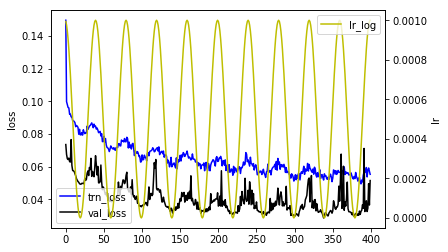

--------------------------------------------
Fold 1


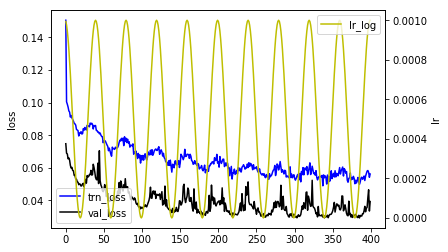

--------------------------------------------
Fold 2


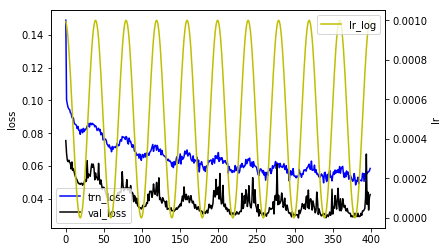

--------------------------------------------
Fold 3


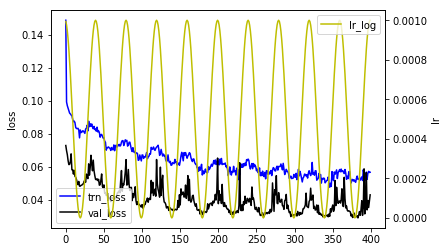

--------------------------------------------
Fold 4


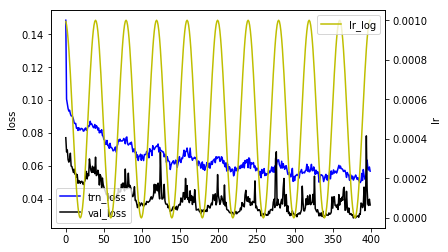

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.title("train loss, validation loss")
for i in range(N_fold):
    print("--------------------------------------------")
    print("Fold %d"%(i))
    fig, ax1 = plt.subplots()
    ax1.plot(result[i]['trn_loss'], label='trn_loss', color='b')
    ax1.plot(result[i]['val_loss'], label='val_loss', color='k')
    ax1.set_ylabel('loss', color='k')
    ax1.legend(loc='lower left')
    # ax1.ylim((0,1.))
    ax2 = ax1.twinx()
    ax2.plot(result[i]['lr_log'], label='lr_log', color='y')
    ax2.set_ylabel('lr', color = 'k')
    ax2.legend(loc='upper right')

    plt.show()

--------------------------------------------
Fold 0


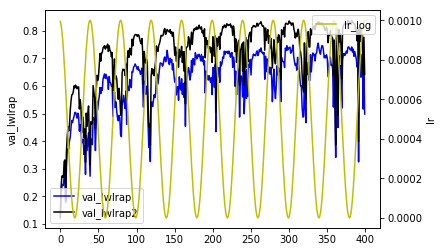

--------------------------------------------
Fold 1


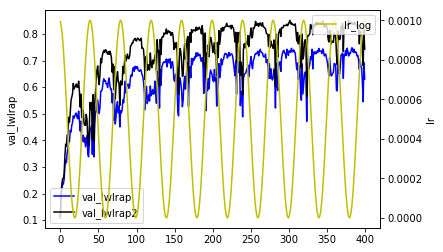

--------------------------------------------
Fold 2


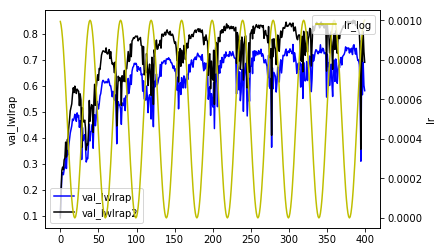

--------------------------------------------
Fold 3


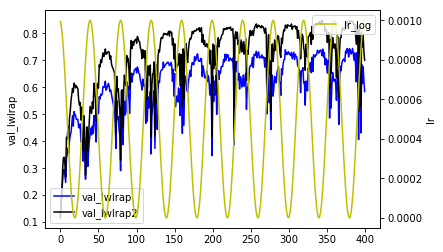

--------------------------------------------
Fold 4


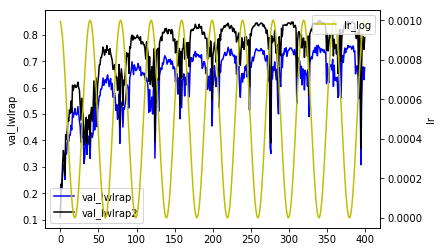

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.title("train loss, validation loss")
for i in range(N_fold):
    print("--------------------------------------------")
    print("Fold %d"%(i))
    fig, ax1 = plt.subplots()
    ax1.plot(result[i]['val_lwlrap'], label='val_lwlrap', color='b')
    ax1.plot(result[i]['val_lwlrap2'], label='val_lwlrap2', color='k')
    ax1.set_ylabel('val_lwlrap', color='k')
    ax1.legend(loc='lower left')
    # ax1.ylim((0,1.))
    ax2 = ax1.twinx()
    ax2.plot(result[i]['lr_log'], label='lr_log', color='y')
    ax2.set_ylabel('lr', color = 'k')
    ax2.legend(loc='upper right')

    plt.show()

### predict

In [29]:
def predict_model(test_fnames, x_test, test_transforms, model_path, num_classes, tta=25):
    batch_size = 32

    test_dataset = FATTestDataset(test_fnames, x_test, test_transforms, tta=tta)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
#    model = Classifier(num_classes=num_classes)

    model = model_ft
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()
    
    all_outputs, all_fnames = [], []

    pb = progress_bar(test_loader)
    for images, fnames in pb:
        preds = torch.sigmoid(model(images.cuda()).detach())
        all_outputs.append(preds.cpu().numpy())
        all_fnames.extend(fnames)

    test_preds = pd.DataFrame(data=np.concatenate(all_outputs),
                              index=all_fnames,
                              columns=map(str, range(num_classes)))
    test_preds = test_preds.groupby(level=0).mean()

    return test_preds

In [30]:
# torch.cuda.set_device(0)
start_time = time.time()
pred_avg = []
for ifold in range(N_fold):
    pre_model = model_path + str(ifold) + '_tta1.pt'
    csv_path = output_path + str(ifold) + '_tta1.csv'
    test_preds = predict_model(test_df['fname'], x_test, transforms_dict['test'], pre_model, num_classes)
    test_df[labels] = test_preds.values
    test_df.to_csv(csv_path, index=False)
    pred_avg.append(test_preds)

test_df[labels] = sum([pred_avg[i].values for i in range(N_fold)]) / N_fold
test_df.to_csv(output_path + '_tta1_avg.csv', index=False)
elapsed = time.time() - start_time
print(f'Prediction time: {elapsed:.0f}s')

Prediction time: 367s


In [31]:
test_df.head(5)

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,000ccb97.wav,0.000457,0.000415,0.004588,0.000110,0.002762,0.072387,0.014461,0.000865,0.005694,...,0.000409,0.000203,0.000338,0.000757,0.000775,0.000183,0.007059,0.001965,0.002100,0.000972
1,0012633b.wav,0.122326,0.000645,0.003944,0.008217,0.006760,0.009459,0.006489,0.005171,0.003956,...,0.008025,0.010255,0.001371,0.013388,0.003458,0.004836,0.003432,0.007850,0.007002,0.046021
2,001ed5f1.wav,0.002874,0.002150,0.002904,0.004385,0.002439,0.032032,0.004112,0.005282,0.002093,...,0.002355,0.002322,0.001116,0.010441,0.004505,0.006894,0.002292,0.005450,0.001641,0.003567
3,00294be0.wav,0.001842,0.000146,0.001472,0.000652,0.005348,0.002813,0.002326,0.001324,0.001039,...,0.001922,0.000377,0.004552,0.003684,0.002702,0.000538,0.002853,0.013412,0.002279,0.017151
4,003fde7a.wav,0.000767,0.002953,0.002521,0.000447,0.006945,0.004196,0.005748,0.001367,0.656619,...,0.001471,0.000338,0.000713,0.000778,0.001246,0.000246,0.001839,0.001208,0.002117,0.000884


In [32]:
# torch.cuda.set_device(0)
start_time = time.time()
pred_avg = []
for ifold in range(N_fold):
    pre_model = model_path + str(ifold) + '_tta1.pt'
    csv_path = output_path + str(ifold) + '_tta1.csv'
    test_preds = predict_model(test_df['fname'], x_test, transforms_dict['test'], pre_model, num_classes)
    test_df[labels] = test_preds.values
    test_df.to_csv(csv_path, index=False)
    pred_avg.append(test_preds)
    pre_model = model_path + str(ifold) + '_s.pt'
    csv_path = output_path + str(ifold) + '_s.csv'
    test_preds = predict_model(test_df['fname'], x_test, transforms_dict['test'], pre_model, num_classes)
    test_df[labels] = test_preds.values
    test_df.to_csv(csv_path, index=False)
    pred_avg.append(test_preds)

test_df[labels] = sum([pred_avg[i].values for i in range(N_fold*2)]) / N_fold/2
test_df.to_csv(output_path + '_all_avg.csv', index=False)
elapsed = time.time() - start_time
print(f'Prediction time: {elapsed:.0f}s')

Prediction time: 737s


In [33]:
# 清除GPU存储
torch.cuda.empty_cache()